In [1]:
!nvidia-smi

Tue Mar 23 17:14:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00135961days (117.47sec)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [32]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp "drive/My Drive/ImageNet/cortical_ImagenetTrain2.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [8]:
!unzip -nq "cortical_ImagenetTrain2.zip"
!unzip -nq "cortical_ImagenetTest2.zip"

In [9]:
def make_path_list(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list


In [10]:
rootpathTrain ='cortical_ImagenetTrain2/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [11]:
def str_convert(label):
    df = pd.DataFrame(({'label_' : label}))
    df['label_'] = df['label_'].astype('category')
    df.dtypes
    df['label'] = df['label_'].cat.codes
    label = df['label'].tolist()

    return label

In [12]:
class ImageNetDataset(data.Dataset):
    def __init__(self, img_list, phase, transform):
        self.img_list = img_list
        self.label_name = [x.split("/")[1] for x in img_list]
        self.label = str_convert(self.label_name)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        """
        Return pre-processed tensor images and labels
        """
        #img, anno_class_img, label = self.pull_item(index)
        #return img, anno_class_img, label
        img, label = self.pull_item(index)
        return img, label
    
    def get_label_relation(self):
        df = pd.DataFrame({'name' : self.label_name, 'num' : self.label})
        classes_list=df[~df.duplicated()].sort_values(by='num')['name'].values.tolist()
        
        return classes_list

    def pull_item(self, index):
        # read image
        image_file_path = self.img_list[index]
        img = PIL.Image.open(image_file_path).convert("RGB")   # [height][width][RGB]
        
        # transform
        #img = transforms.functional.to_tensor(img)
        #anno_class_img = torch.from_numpy(anno_class_img)
        img = self.transform(img)
        #anno_class_img = self.transform(anno_class_img)

        # label
        label = self.label[index]
        
        #return img, anno_class_img, label
        return img, label

In [13]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [14]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [15]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [16]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [17]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

14164

In [18]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


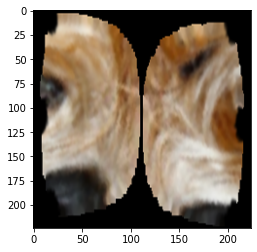

In [19]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [20]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [21]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [22]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [24]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 100

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Loss function

In [25]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### VGG16 fine tuning

In [33]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)

params_to_update_1 stores： features.0.weight
params_to_update_1 stores： features.0.bias
params_to_update_1 stores： features.2.weight
params_to_update_1 stores： features.2.bias
params_to_update_1 stores： features.5.weight
params_to_update_1 stores： features.5.bias
params_to_update_1 stores： features.7.weight
params_to_update_1 stores： features.7.bias
params_to_update_1 stores： features.10.weight
params_to_update_1 stores： features.10.bias
params_to_update_1 stores： features.12.weight
params_to_update_1 stores： features.12.bias
params_to_update_1 stores： features.14.weight
params_to_update_1 stores： features.14.bias
params_to_update_1 stores： features.17.weight
params_to_update_1 stores： features.17.bias
params_to_update_1 stores： features.19.weight
params_to_update_1 stores： features.19.bias
params_to_update_1 stores： features.21.weight
params_to_update_1 stores： features.21.bias
params_to_update_1 stores： features.24.weight
params_to_update_1 stores： features.24.bias
params_to_update_1

In [35]:
vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

### Training & Test for model

In [36]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [37]:
LOAD_STATE = False
EPOCH = 100             # This values need to check the latest tar ffile name with epoch.
name = "04_vgg16"
folder_name = "VGG_fine"

if LOAD_STATE:
    stats=[];
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    use_pretrained = True
    best_model = models.vgg11(pretrained=use_pretrained)
    best_model.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)
    best_model.cuda()
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [38]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/100
-------------



5198
train Loss: 0.0630 Acc: 36.6987



1867
val Loss: 0.0467 Acc: 52.7401
-------------
Epoch 2/100
-------------



7761
train Loss: 0.0439 Acc: 54.7938



2053
val Loss: 0.0408 Acc: 57.9944
-------------
Epoch 3/100
-------------



8699
train Loss: 0.0373 Acc: 61.4163



2209
val Loss: 0.0367 Acc: 62.4011
-------------
Epoch 4/100
-------------



9307
train Loss: 0.0326 Acc: 65.7088



2239
val Loss: 0.0362 Acc: 63.2486
-------------
Epoch 5/100
-------------



9820
train Loss: 0.0293 Acc: 69.3307



2285
val Loss: 0.0346 Acc: 64.5480
-------------
Epoch 6/100
-------------



10261
train Loss: 0.0261 Acc: 72.4442



2262
val Loss: 0.0349 Acc: 63.8983
-------------
Epoch 7/100
-------------



10740
train Loss: 0.0228 Acc: 75.8260



2308
val Loss: 0.0349 Acc: 65.1977
-------------
Epoch 8/100
-------------



11118
train Loss: 0.0202 Acc: 78.4948



2315
val Loss: 0.0351 Acc: 65.3955
-------------
Epoch 9/100
-------------



11545
train Loss: 0.0175 Acc: 81.5095



2360
val Loss: 0.0346 Acc: 66.6667
-------------
Epoch 10/100
-------------



11931
train Loss: 0.0146 Acc: 84.2347



2333
val Loss: 0.0369 Acc: 65.9040
-------------
Epoch 11/100
-------------



12272
train Loss: 0.0125 Acc: 86.6422



2335
val Loss: 0.0385 Acc: 65.9605
-------------
Epoch 12/100
-------------



12591
train Loss: 0.0107 Acc: 88.8944



2322
val Loss: 0.0393 Acc: 65.5932
-------------
Epoch 13/100
-------------



12851
train Loss: 0.0086 Acc: 90.7300



2322
val Loss: 0.0421 Acc: 65.5932
-------------
Epoch 14/100
-------------



13174
train Loss: 0.0068 Acc: 93.0104



2348
val Loss: 0.0435 Acc: 66.3277
-------------
Epoch 15/100
-------------



13317
train Loss: 0.0056 Acc: 94.0201



2347
val Loss: 0.0463 Acc: 66.2994
-------------
Epoch 16/100
-------------



13454
train Loss: 0.0048 Acc: 94.9873



2329
val Loss: 0.0496 Acc: 65.7910
-------------
Epoch 17/100
-------------



13586
train Loss: 0.0039 Acc: 95.9192



2347
val Loss: 0.0495 Acc: 66.2994
-------------
Epoch 18/100
-------------



13679
train Loss: 0.0032 Acc: 96.5758



2316
val Loss: 0.0532 Acc: 65.4237
-------------
Epoch 19/100
-------------



13754
train Loss: 0.0028 Acc: 97.1053



2338
val Loss: 0.0530 Acc: 66.0452
-------------
Epoch 20/100
-------------



13813
train Loss: 0.0024 Acc: 97.5219



2379
val Loss: 0.0539 Acc: 67.2034
-------------
Epoch 21/100
-------------



13818
train Loss: 0.0023 Acc: 97.5572



2322
val Loss: 0.0565 Acc: 65.5932
-------------
Epoch 22/100
-------------



13921
train Loss: 0.0017 Acc: 98.2844



2362
val Loss: 0.0595 Acc: 66.7232
-------------
Epoch 23/100
-------------



13930
train Loss: 0.0016 Acc: 98.3479



2338
val Loss: 0.0604 Acc: 66.0452
-------------
Epoch 24/100
-------------



13974
train Loss: 0.0014 Acc: 98.6586



2348
val Loss: 0.0602 Acc: 66.3277
-------------
Epoch 25/100
-------------



13983
train Loss: 0.0013 Acc: 98.7221



2338
val Loss: 0.0613 Acc: 66.0452
-------------
Epoch 26/100
-------------



13999
train Loss: 0.0013 Acc: 98.8351



2360
val Loss: 0.0604 Acc: 66.6667
-------------
Epoch 27/100
-------------



14026
train Loss: 0.0010 Acc: 99.0257



2347
val Loss: 0.0665 Acc: 66.2994
-------------
Epoch 28/100
-------------



14053
train Loss: 0.0008 Acc: 99.2163



2351
val Loss: 0.0671 Acc: 66.4124
-------------
Epoch 29/100
-------------



14037
train Loss: 0.0010 Acc: 99.1034



2353
val Loss: 0.0621 Acc: 66.4689
-------------
Epoch 30/100
-------------



14047
train Loss: 0.0009 Acc: 99.1740



2348
val Loss: 0.0650 Acc: 66.3277
-------------
Epoch 31/100
-------------



14042
train Loss: 0.0009 Acc: 99.1387



2324
val Loss: 0.0647 Acc: 65.6497
-------------
Epoch 32/100
-------------



14083
train Loss: 0.0007 Acc: 99.4281



2383
val Loss: 0.0677 Acc: 67.3164
-------------
Epoch 33/100
-------------



14069
train Loss: 0.0007 Acc: 99.3293



2351
val Loss: 0.0662 Acc: 66.4124
-------------
Epoch 34/100
-------------



14082
train Loss: 0.0007 Acc: 99.4211



2371
val Loss: 0.0664 Acc: 66.9774
-------------
Epoch 35/100
-------------



14106
train Loss: 0.0005 Acc: 99.5905



2354
val Loss: 0.0714 Acc: 66.4972
-------------
Epoch 36/100
-------------



14058
train Loss: 0.0007 Acc: 99.2516



2335
val Loss: 0.0678 Acc: 65.9605
-------------
Epoch 37/100
-------------



14089
train Loss: 0.0006 Acc: 99.4705



2332
val Loss: 0.0694 Acc: 65.8757
-------------
Epoch 38/100
-------------



14120
train Loss: 0.0004 Acc: 99.6894



2368
val Loss: 0.0695 Acc: 66.8927
-------------
Epoch 39/100
-------------



14109
train Loss: 0.0004 Acc: 99.6117



2361
val Loss: 0.0694 Acc: 66.6949
-------------
Epoch 40/100
-------------



14113
train Loss: 0.0004 Acc: 99.6399



2343
val Loss: 0.0714 Acc: 66.1864
-------------
Epoch 41/100
-------------



14131
train Loss: 0.0003 Acc: 99.7670



2357
val Loss: 0.0709 Acc: 66.5819
-------------
Epoch 42/100
-------------



14091
train Loss: 0.0005 Acc: 99.4846



2367
val Loss: 0.0709 Acc: 66.8644
-------------
Epoch 43/100
-------------



14114
train Loss: 0.0004 Acc: 99.6470



2330
val Loss: 0.0710 Acc: 65.8192
-------------
Epoch 44/100
-------------



14132
train Loss: 0.0003 Acc: 99.7741



2384
val Loss: 0.0735 Acc: 67.3446
-------------
Epoch 45/100
-------------



14124
train Loss: 0.0003 Acc: 99.7176



2378
val Loss: 0.0720 Acc: 67.1751
-------------
Epoch 46/100
-------------



14119
train Loss: 0.0003 Acc: 99.6823



2361
val Loss: 0.0751 Acc: 66.6949
-------------
Epoch 47/100
-------------



14117
train Loss: 0.0004 Acc: 99.6682



2349
val Loss: 0.0739 Acc: 66.3559
-------------
Epoch 48/100
-------------



14125
train Loss: 0.0003 Acc: 99.7247



2374
val Loss: 0.0720 Acc: 67.0621
-------------
Epoch 49/100
-------------



14128
train Loss: 0.0003 Acc: 99.7458



2344
val Loss: 0.0748 Acc: 66.2147
-------------
Epoch 50/100
-------------



14114
train Loss: 0.0004 Acc: 99.6470



2363
val Loss: 0.0750 Acc: 66.7514
-------------
Epoch 51/100
-------------



14127
train Loss: 0.0003 Acc: 99.7388



2377
val Loss: 0.0732 Acc: 67.1469
-------------
Epoch 52/100
-------------



14137
train Loss: 0.0002 Acc: 99.8094



2349
val Loss: 0.0771 Acc: 66.3559
-------------
Epoch 53/100
-------------



14136
train Loss: 0.0002 Acc: 99.8023



2366
val Loss: 0.0742 Acc: 66.8362
-------------
Epoch 54/100
-------------



14121
train Loss: 0.0003 Acc: 99.6964



2362
val Loss: 0.0724 Acc: 66.7232
-------------
Epoch 55/100
-------------



14134
train Loss: 0.0002 Acc: 99.7882



2373
val Loss: 0.0739 Acc: 67.0339
-------------
Epoch 56/100
-------------



14144
train Loss: 0.0002 Acc: 99.8588



2384
val Loss: 0.0775 Acc: 67.3446
-------------
Epoch 57/100
-------------



14144
train Loss: 0.0002 Acc: 99.8588



2380
val Loss: 0.0800 Acc: 67.2316
-------------
Epoch 58/100
-------------



14132
train Loss: 0.0002 Acc: 99.7741



2361
val Loss: 0.0754 Acc: 66.6949
-------------
Epoch 59/100
-------------



14123
train Loss: 0.0003 Acc: 99.7105



2310
val Loss: 0.0792 Acc: 65.2542
-------------
Epoch 60/100
-------------



14136
train Loss: 0.0002 Acc: 99.8023



2388
val Loss: 0.0763 Acc: 67.4576
-------------
Epoch 61/100
-------------



14123
train Loss: 0.0003 Acc: 99.7105



2353
val Loss: 0.0777 Acc: 66.4689
-------------
Epoch 62/100
-------------



14125
train Loss: 0.0003 Acc: 99.7247



2361
val Loss: 0.0732 Acc: 66.6949
-------------
Epoch 63/100
-------------



14138
train Loss: 0.0002 Acc: 99.8164



2350
val Loss: 0.0737 Acc: 66.3842
-------------
Epoch 64/100
-------------



14142
train Loss: 0.0002 Acc: 99.8447



2352
val Loss: 0.0769 Acc: 66.4407
-------------
Epoch 65/100
-------------



14131
train Loss: 0.0002 Acc: 99.7670



2344
val Loss: 0.0763 Acc: 66.2147
-------------
Epoch 66/100
-------------



14153
train Loss: 0.0001 Acc: 99.9223



2342
val Loss: 0.0780 Acc: 66.1582
-------------
Epoch 67/100
-------------



14137
train Loss: 0.0002 Acc: 99.8094



2356
val Loss: 0.0783 Acc: 66.5537
-------------
Epoch 68/100
-------------



14151
train Loss: 0.0001 Acc: 99.9082



2341
val Loss: 0.0792 Acc: 66.1299
-------------
Epoch 69/100
-------------



14117
train Loss: 0.0003 Acc: 99.6682



2342
val Loss: 0.0801 Acc: 66.1582
-------------
Epoch 70/100
-------------



14143
train Loss: 0.0002 Acc: 99.8517



2368
val Loss: 0.0760 Acc: 66.8927
-------------
Epoch 71/100
-------------



14149
train Loss: 0.0001 Acc: 99.8941



2360
val Loss: 0.0775 Acc: 66.6667
-------------
Epoch 72/100
-------------



14135
train Loss: 0.0002 Acc: 99.7953



2377
val Loss: 0.0757 Acc: 67.1469
-------------
Epoch 73/100
-------------



14136
train Loss: 0.0002 Acc: 99.8023



2379
val Loss: 0.0747 Acc: 67.2034
-------------
Epoch 74/100
-------------



14154
train Loss: 0.0001 Acc: 99.9294



2377
val Loss: 0.0770 Acc: 67.1469
-------------
Epoch 75/100
-------------



14136
train Loss: 0.0002 Acc: 99.8023



2374
val Loss: 0.0768 Acc: 67.0621
-------------
Epoch 76/100
-------------



14146
train Loss: 0.0001 Acc: 99.8729



2390
val Loss: 0.0784 Acc: 67.5141
-------------
Epoch 77/100
-------------



14142
train Loss: 0.0001 Acc: 99.8447



2368
val Loss: 0.0782 Acc: 66.8927
-------------
Epoch 78/100
-------------



14142
train Loss: 0.0002 Acc: 99.8447



2366
val Loss: 0.0779 Acc: 66.8362
-------------
Epoch 79/100
-------------



14158
train Loss: 0.0001 Acc: 99.9576



2388
val Loss: 0.0811 Acc: 67.4576
-------------
Epoch 80/100
-------------



14156
train Loss: 0.0001 Acc: 99.9435



2354
val Loss: 0.0825 Acc: 66.4972
-------------
Epoch 81/100
-------------



14142
train Loss: 0.0002 Acc: 99.8447



2383
val Loss: 0.0779 Acc: 67.3164
-------------
Epoch 82/100
-------------



14143
train Loss: 0.0001 Acc: 99.8517



2325
val Loss: 0.0816 Acc: 65.6780
-------------
Epoch 83/100
-------------



14134
train Loss: 0.0002 Acc: 99.7882



2379
val Loss: 0.0783 Acc: 67.2034
-------------
Epoch 84/100
-------------



14155
train Loss: 0.0001 Acc: 99.9365



2363
val Loss: 0.0805 Acc: 66.7514
-------------
Epoch 85/100
-------------



14154
train Loss: 0.0001 Acc: 99.9294



2363
val Loss: 0.0834 Acc: 66.7514
-------------
Epoch 86/100
-------------



14152
train Loss: 0.0001 Acc: 99.9153



2363
val Loss: 0.0790 Acc: 66.7514
-------------
Epoch 87/100
-------------



14147
train Loss: 0.0001 Acc: 99.8800



2374
val Loss: 0.0805 Acc: 67.0621
-------------
Epoch 88/100
-------------



14156
train Loss: 0.0001 Acc: 99.9435



2373
val Loss: 0.0826 Acc: 67.0339
-------------
Epoch 89/100
-------------



14163
train Loss: 0.0000 Acc: 99.9929



2397
val Loss: 0.0830 Acc: 67.7119
-------------
Epoch 90/100
-------------



14162
train Loss: 0.0000 Acc: 99.9859



2393
val Loss: 0.0845 Acc: 67.5989
-------------
Epoch 91/100
-------------



14121
train Loss: 0.0003 Acc: 99.6964



2342
val Loss: 0.0766 Acc: 66.1582
-------------
Epoch 92/100
-------------



14148
train Loss: 0.0002 Acc: 99.8870



2358
val Loss: 0.0771 Acc: 66.6102
-------------
Epoch 93/100
-------------



14156
train Loss: 0.0001 Acc: 99.9435



2374
val Loss: 0.0799 Acc: 67.0621
-------------
Epoch 94/100
-------------



14161
train Loss: 0.0000 Acc: 99.9788



2388
val Loss: 0.0810 Acc: 67.4576
-------------
Epoch 95/100
-------------



14151
train Loss: 0.0001 Acc: 99.9082



2354
val Loss: 0.0820 Acc: 66.4972
-------------
Epoch 96/100
-------------



14151
train Loss: 0.0001 Acc: 99.9082



2355
val Loss: 0.0822 Acc: 66.5254
-------------
Epoch 97/100
-------------



14150
train Loss: 0.0001 Acc: 99.9012



2354
val Loss: 0.0823 Acc: 66.4972
-------------
Epoch 98/100
-------------



14138
train Loss: 0.0002 Acc: 99.8164



2356
val Loss: 0.0776 Acc: 66.5537
-------------
Epoch 99/100
-------------



14158
train Loss: 0.0001 Acc: 99.9576



2360
val Loss: 0.0806 Acc: 66.6667
-------------
Epoch 100/100
-------------



14147
train Loss: 0.0001 Acc: 99.8800



2360
val Loss: 0.0793 Acc: 66.6667
-------------
Lowest training loss 3.4677349949249104e-05
Lowest validation loss 0.034563971862281107
Highest training accuracy 99.99293984750071
Highest validation accuracy 67.71186440677967
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/04_vgg16_Loss _.png04_vgg16_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_vgg16_Accuracy _.png04_vgg16_Accuracy _.png


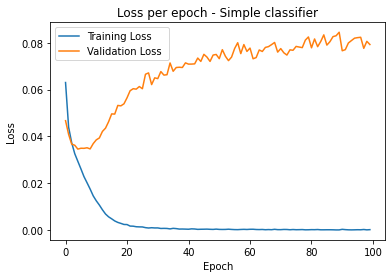

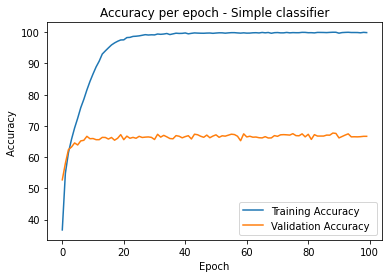

In [39]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.9375 
Testing Accuracy: 1287/2000 (64.35%)
apple Class Accuracy: 52/100 (52.00%)
banana Class Accuracy: 63/100 (63.00%)
bear Class Accuracy: 74/100 (74.00%)
bell_pepper Class Accuracy: 61/100 (61.00%)
bird Class Accuracy: 68/100 (68.00%)
broccoli Class Accuracy: 73/100 (73.00%)
cat Class Accuracy: 65/100 (65.00%)
cauliflower Class Accuracy: 57/100 (57.00%)
cow Class Accuracy: 39/100 (39.00%)
dog Class Accuracy: 38/100 (38.00%)
elephant Class Accuracy: 72/100 (72.00%)
fox Class Accuracy: 69/100 (69.00%)
goat Class Accuracy: 42/100 (42.00%)
horse Class Accuracy: 57/100 (57.00%)
mashed_potato Class Accuracy: 70/100 (70.00%)
orange Class Accuracy: 74/100 (74.00%)
pineapple Class Accuracy: 79/100 (79.00%)
pomegranate Class Accuracy: 83/100 (83.00%)
tomato Class Accuracy: 67/100 (67.00%)
zebra Class Accuracy: 84/100 (84.00%)
Classifier has Acc=0.643 P=0.644 R=0.643 F1=0.641
               precision    recall  f1-score   support

        apple       0.55      0.52      0.53     

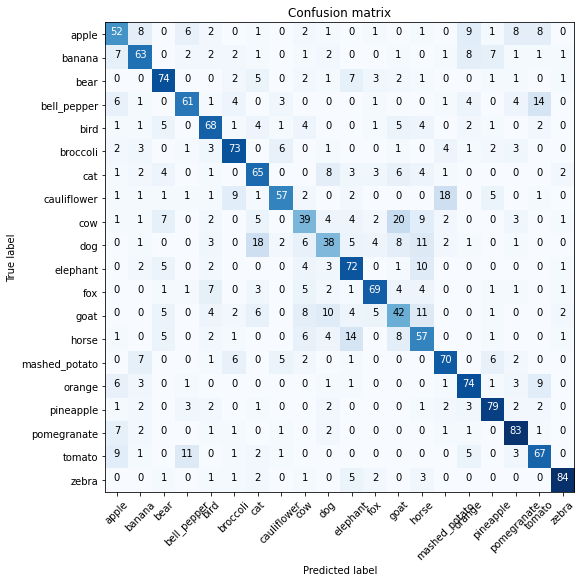

In [40]:
result = test_model(best_vgg2,criterion, name)